In [1]:
import numpy as np
import pandas as pd
from scipy.stats import boxcox 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error ,r2_score
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from pandas.plotting import scatter_matrix
from sklearn.feature_selection import RFE
from sklearn.base import BaseEstimator, RegressorMixin

In [2]:
class CustomGradientDescent(BaseEstimator, RegressorMixin):
    def __init__(self, learning_rate=0.01, n_iterations=1000, alpha=None):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.theta = None  # Initialize theta in fit method
        self.alpha = alpha  # Initialize alpha

    def fit(self, X, y, n_iter=None, alpha=None):
        if n_iter is not None:
            self.n_iterations = n_iter
        if alpha is not None:
            self.alpha = alpha if alpha is not None else 0.01  # Set alpha here

        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        num_of_features = X.shape[1]
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        theta = np.random.rand(num_of_features + 1, 1)

        for i in range(self.n_iterations):
            gradients = (2/X.shape[0]) * X_b.T.dot(X_b.dot(theta) - y)
            theta = theta - self.alpha * gradients
        self.theta = theta
        return self

    def stochastic_GD(self, X, y, n_iter, alpha):
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        num_of_features = X.shape[1]
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        theta = np.random.rand(num_of_features + 1, 1)

        for j in range(n_iter):
            for i in range(X.shape[0]):
                random_idx = np.random.randint(X.shape[0])
                xi = X_b[random_idx:random_idx+1]
                yi = y[random_idx:random_idx+1]
                gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
                theta = theta - alpha * gradients
        self.theta = theta
        return self

    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b.dot(self.theta)

    @property
    def coef_(self):
        return self.theta[1:].flatten()

# Wrapper class with coef_ attribute
class CustomGradientDescentWrapper(CustomGradientDescent):
    @property
    def coef_(self):
        return self.theta[1:].flatten()


In [3]:
def gradient_descent(X,Y,n_iter,alpha):
    X = np.array(X)
    Y = np.array(Y).reshape(-1, 1)  # Ensure Y has shape (m, 1)
    num_of_features = X.shape[1]
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    theta = np.random.rand(num_of_features + 1, 1)

    for i in range(n_iter):
        gradients = (2/X.shape[0]) * X_b.T.dot(X_b.dot(theta) - Y)
        theta = theta -  alpha * gradients
        
    return theta

In [4]:
def stochastic_GD(X, Y, n_iter, alpha):
    X = np.array(X)
    Y = np.array(Y).reshape(-1, 1)
    num_of_features = X.shape[1]
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    theta = np.random.rand(num_of_features + 1, 1)

    for j in range(n_iter):
        for i in range(X.shape[0]):
            random_idx = np.random.randint(X.shape[0])
            xi = X_b[random_idx:random_idx+1]
            yi = Y[random_idx:random_idx+1]
            gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
            theta = theta - alpha * gradients
    return theta
    

In [5]:
def predict(X,theta):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    return X_b.dot(theta)

In [6]:
# loading data 
df = pd.read_csv('F:\Matrials\CORELIA Internship\ML tasks\EmployeeBurnout1.csv')

In [7]:
df.head(20)

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,9/30/2008,Female,Service,No,2,3.0,3.8,0.16
1,fffe3700360033003500,11/30/2008,Male,Service,Yes,1,2.0,5.0,0.36
2,fffe31003300320037003900,3/10/2008,Female,Product,Yes,2,NaN,5.8,0.49
3,fffe32003400380032003900,11/3/2008,Male,Service,Yes,1,1.0,2.6,0.20
4,fffe31003900340031003600,7/24/2008,Female,Service,No,3,7.0,6.9,0.52
5,fffe3300350037003500,11/26/2008,Male,Product,Yes,2,4.0,3.6,0.29
6,fffe33003300340039003100,1/2/2008,Female,Service,No,3,6.0,7.9,0.62
7,fffe32003600320037003400,10/31/2008,Female,Service,Yes,2,4.0,4.4,0.33
8,fffe32003200300034003700,12/27/2008,Female,Service,No,3,6.0,NaN,0.56
9,fffe31003600320030003200,3/9/2008,Female,Product,No,3,6.0,NaN,0.67


In [8]:
df.isna().sum()

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  int64  
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 1.6+ MB


### Outliers detection

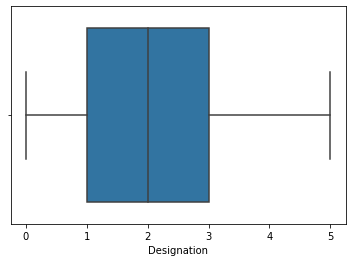

In [10]:
# checking ou;iers in Designation
sns.boxplot(x=df['Designation'])
plt.show()

C:\Users\01272\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


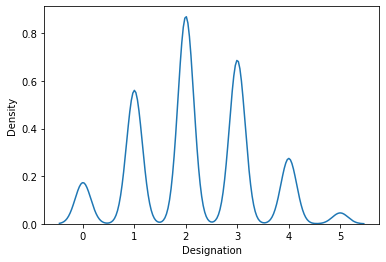

In [11]:
sns.distplot(df['Designation'],hist=False,kde=True)
plt.show()

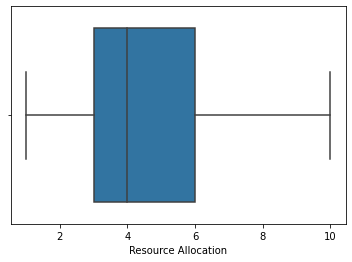

In [12]:
# checking ou;iers in Resource Allocation
sns.boxplot(x=df['Resource Allocation'])
plt.show()

C:\Users\01272\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


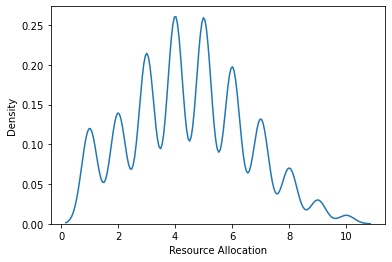

In [13]:
sns.distplot(df['Resource Allocation'],hist=False,kde=True)
plt.show()

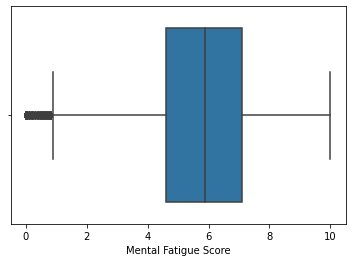

In [14]:
# checking ou;iers in Mental Fatigue Score
sns.boxplot(x=df['Mental Fatigue Score'])
plt.show()

C:\Users\01272\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


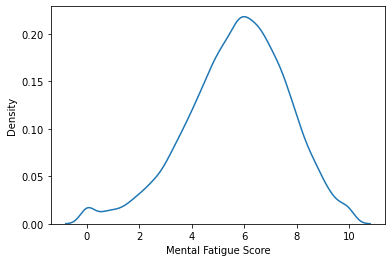

In [15]:
sns.distplot(df['Mental Fatigue Score'],hist=False,kde=True)
plt.show()

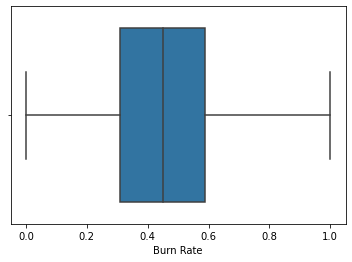

In [16]:
# checking ou;iers in Burn Rate
sns.boxplot(x=df['Burn Rate'])
plt.show()

C:\Users\01272\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


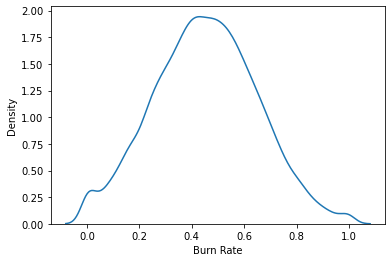

In [17]:
sns.distplot(df['Burn Rate'],hist=False,kde=True)
plt.show()

In [18]:
'''
trnsformed_data , best_lambda = boxcox(df['Mental Fatigue Score']+5, method='pearsonr')
'''
'''
df['Mental Fatigue Score'] = np.log10(df['Mental Fatigue Score'])

'''

"\ndf['Mental Fatigue Score'] = np.log10(df['Mental Fatigue Score'])\n\n"

### filling nan values

In [19]:
df['Designation'].fillna(df['Designation'].mean() , inplace=True)

In [20]:
df['Resource Allocation'].fillna(df['Resource Allocation'].mean(),inplace=True)

In [21]:
df['Mental Fatigue Score'].fillna(df['Mental Fatigue Score'].median(),inplace=True)

In [22]:
df['Burn Rate'].fillna(df['Burn Rate'].mean(),inplace=True)

In [23]:
df.isna().sum()

Employee ID             0
Date of Joining         0
Gender                  0
Company Type            0
WFH Setup Available     0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
Burn Rate               0
dtype: int64

### encoding categorical data

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  int64  
 6   Resource Allocation   22750 non-null  float64
 7   Mental Fatigue Score  22750 non-null  float64
 8   Burn Rate             22750 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 1.6+ MB


In [25]:
df['Company Type'].unique()

array(['Service', 'Product'], dtype=object)

In [26]:
df = df.join(pd.get_dummies(df['Company Type'],drop_first=True))

In [27]:
df.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Service
0,fffe32003000360033003200,9/30/2008,Female,Service,No,2,3.000000,3.8,0.16,1
1,fffe3700360033003500,11/30/2008,Male,Service,Yes,1,2.000000,5.0,0.36,1
2,fffe31003300320037003900,3/10/2008,Female,Product,Yes,2,4.481398,5.8,0.49,0
3,fffe32003400380032003900,11/3/2008,Male,Service,Yes,1,1.000000,2.6,0.20,1
4,fffe31003900340031003600,7/24/2008,Female,Service,No,3,7.000000,6.9,0.52,1


In [28]:
df = df.join(pd.get_dummies(df['Gender'], drop_first=True))

In [29]:
df.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Service,Male
0,fffe32003000360033003200,9/30/2008,Female,Service,No,2,3.000000,3.8,0.16,1,0
1,fffe3700360033003500,11/30/2008,Male,Service,Yes,1,2.000000,5.0,0.36,1,1
2,fffe31003300320037003900,3/10/2008,Female,Product,Yes,2,4.481398,5.8,0.49,0,0
3,fffe32003400380032003900,11/3/2008,Male,Service,Yes,1,1.000000,2.6,0.20,1,1
4,fffe31003900340031003600,7/24/2008,Female,Service,No,3,7.000000,6.9,0.52,1,0


In [30]:
df = df.join(pd.get_dummies(df['WFH Setup Available'],drop_first=True))

In [31]:
df.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Service,Male,Yes
0,fffe32003000360033003200,9/30/2008,Female,Service,No,2,3.000000,3.8,0.16,1,0,0
1,fffe3700360033003500,11/30/2008,Male,Service,Yes,1,2.000000,5.0,0.36,1,1,1
2,fffe31003300320037003900,3/10/2008,Female,Product,Yes,2,4.481398,5.8,0.49,0,0,1
3,fffe32003400380032003900,11/3/2008,Male,Service,Yes,1,1.000000,2.6,0.20,1,1,1
4,fffe31003900340031003600,7/24/2008,Female,Service,No,3,7.000000,6.9,0.52,1,0,0


In [32]:
df.drop(['Gender','Company Type','WFH Setup Available'],axis=1,inplace=True)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Designation           22750 non-null  int64  
 3   Resource Allocation   22750 non-null  float64
 4   Mental Fatigue Score  22750 non-null  float64
 5   Burn Rate             22750 non-null  float64
 6   Service               22750 non-null  uint8  
 7   Male                  22750 non-null  uint8  
 8   Yes                   22750 non-null  uint8  
dtypes: float64(3), int64(1), object(2), uint8(3)
memory usage: 1.1+ MB


In [34]:
df.drop(['Employee ID'],axis=1, inplace=True)


In [35]:
df['Date of Joining'] = pd.to_datetime(df['Date of Joining'])

In [36]:
df['Year'] = df['Date of Joining'].dt.year

In [37]:
df['month'] = df['Date of Joining'].dt.month

In [38]:
df['day'] = df['Date of Joining'].dt.day

In [39]:
df.head()

,Date of Joining,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Service,Male,Yes,Year,month,day
0,2008-09-30,2,3.000000,3.8,0.16,1,0,0,2008,9,30
1,2008-11-30,1,2.000000,5.0,0.36,1,1,1,2008,11,30
2,2008-03-10,2,4.481398,5.8,0.49,0,0,1,2008,3,10
3,2008-11-03,1,1.000000,2.6,0.20,1,1,1,2008,11,3
4,2008-07-24,3,7.000000,6.9,0.52,1,0,0,2008,7,24


In [40]:
df.drop(['Date of Joining'],axis=1,inplace=True)

In [41]:
df.head()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Service,Male,Yes,Year,month,day
0,2,3.000000,3.8,0.16,1,0,0,2008,9,30
1,1,2.000000,5.0,0.36,1,1,1,2008,11,30
2,2,4.481398,5.8,0.49,0,0,1,2008,3,10
3,1,1.000000,2.6,0.20,1,1,1,2008,11,3
4,3,7.000000,6.9,0.52,1,0,0,2008,7,24


In [42]:
df['Year'].unique()

array([2008], dtype=int64)

### scaling features

In [43]:
scaler = StandardScaler()

In [44]:
df.duplicated().sum()

10

In [45]:
df.drop_duplicates(inplace=True)

In [46]:
df.shape

(22740, 10)

In [47]:
x = df.drop('Burn Rate', axis=1)
y = df['Burn Rate'] 

In [50]:
x.shape, y.shape

((22740, 9), (22740,))

In [51]:
column_to_scale = ['Designation','Resource Allocation', 'Mental Fatigue Score','Year','month','day']
df_columns = x[column_to_scale]
df_columns.shape

(22740, 6)

In [52]:
df_scaled_cols = pd.DataFrame(scaler.fit_transform(df_columns), columns=column_to_scale)

In [53]:
df_scaled_cols.isna().sum()

Designation             0
Resource Allocation     0
Mental Fatigue Score    0
Year                    0
month                   0
day                     0
dtype: int64

In [54]:
x.isna().sum()

Designation             0
Resource Allocation     0
Mental Fatigue Score    0
Service                 0
Male                    0
Yes                     0
Year                    0
month                   0
day                     0
dtype: int64

In [55]:
x_scaled = pd.merge(x.drop(column_to_scale, axis=1), df_scaled_cols.set_index(x.index), left_index=True, right_index=True)

In [56]:
x_scaled.isna().sum()

Service                 0
Male                    0
Yes                     0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
Year                    0
month                   0
day                     0
dtype: int64

In [57]:
x_scaled.shape

(22740, 9)

### checking for multicolinearity

In [58]:
x_scaled.corr()

,Service,Male,Yes,Designation,Resource Allocation,Mental Fatigue Score,Year,month,day
Service,1.000000,-0.009583,0.005782,0.006296,0.005776,0.002439,NaN,0.000025,-0.002073
Male,-0.009583,1.000000,-0.073245,0.113090,0.138668,0.138347,NaN,0.000287,-0.005049
Yes,0.005782,-0.073245,1.000000,-0.229553,-0.276077,-0.263064,NaN,-0.004343,0.000182
Designation,0.006296,0.113090,-0.229553,1.000000,0.851999,0.656236,NaN,-0.000874,-0.000224
Resource Allocation,0.005776,0.138668,-0.276077,0.851999,1.000000,0.738888,NaN,0.000038,-0.004961
Mental Fatigue Score,0.002439,0.138347,-0.263064,0.656236,0.738888,1.000000,NaN,0.002133,0.001680
Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,0.000025,0.000287,-0.004343,-0.000874,0.000038,0.002133,NaN,1.000000,0.009139
day,-0.002073,-0.005049,0.000182,-0.000224,-0.004961,0.001680,NaN,0.009139,1.000000


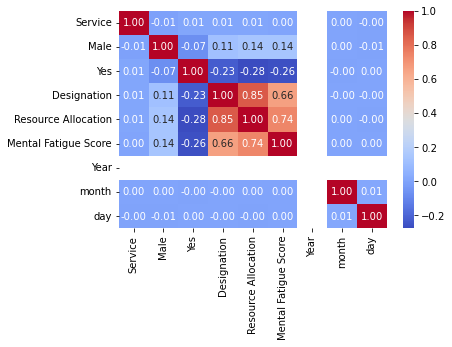

In [59]:
sns.heatmap(x_scaled.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

C:\Users\01272\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:100: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\Users\01272\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:101: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
C:\Users\01272\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:91: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


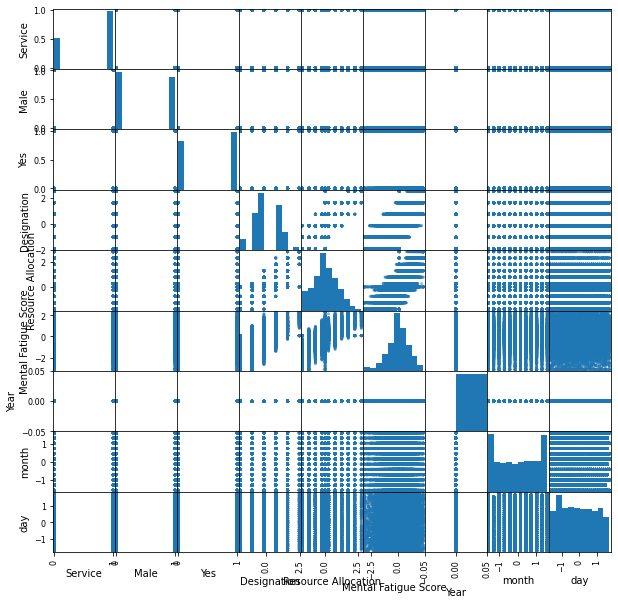

In [60]:
scatter_matrix(x_scaled,figsize=(10, 10), diagonal='hist')
plt.show()

### LR model BGD

In [61]:
x_train , x_test , y_train , y_test = train_test_split(x_scaled,y,test_size=0.3,shuffle=True, random_state=42)

In [62]:
x_train.head()

,Service,Male,Yes,Designation,Resource Allocation,Mental Fatigue Score,Year,month,day
12945,1,1,0,-0.157524,0.000004,1.779359,0.0,-0.148443,-0.656944
15280,1,0,1,-1.919495,-1.754695,-1.499843,0.0,1.014149,1.623665
7033,0,0,1,-0.157524,0.261390,0.085104,0.0,-0.729738,0.369330
1984,1,0,1,-1.038510,-0.746652,-1.499843,0.0,1.014149,1.623665
19832,0,0,1,-0.157524,-1.250673,-0.789350,0.0,1.014149,1.395604


In [63]:
# Create an instance of your custom gradient descent model
custom_model = CustomGradientDescentWrapper(learning_rate=0.01, n_iterations=1000, alpha=0.01)

In [64]:
# Create RFE with your custom regression model
n_features_to_select = 5  # Number of features to select
rfe = RFE(estimator=custom_model, n_features_to_select=n_features_to_select)


In [65]:
# Fit RFE on the training data
rfe.fit(x_train, y_train)

RFE(estimator=CustomGradientDescentWrapper(alpha=0.01), n_features_to_select=5)

In [66]:
# Transform the training and test sets to include only selected features
X_train_selected = rfe.transform(x_train)
X_test_selected = rfe.transform(x_test)

In [67]:
# Train your model on the selected features
custom_model.fit(X_train_selected, y_train)

CustomGradientDescentWrapper(alpha=0.01)

In [68]:
# Evaluate the model on the test set
y_pred = custom_model.predict(X_test_selected)

In [70]:
y_pred

array([[0.7288352 ],
       [0.30443005],
       [0.08631288],
       ...,
       [0.31357217],
       [0.8036933 ],
       [0.61250639]])

In [71]:
mean_squared_error(y_test, y_pred)

0.006358141696389785

In [369]:
# Display the selected features
selected_features = np.where(rfe.support_)[0]
print("Selected Features:", selected_features)

Selected Features: [0 1 4 5 6]


In [72]:
r2_score(y_test, y_pred)

0.8301505177258481

### SGD

In [73]:
# Train your model with SGD on the selected features
custom_model.stochastic_GD(X_train_selected, y_train, n_iter=1000, alpha=0.01)


CustomGradientDescentWrapper(alpha=0.01)

In [74]:
y_pred_sgd = custom_model.predict(X_test_selected)

In [75]:
mean_squared_error(y_test, y_pred_sgd)

0.006579238004438126

In [76]:
r2_score(y_test, y_pred_sgd)

0.8242442175444509